## NEPTUNE

In [ ]:
!pip install neptune-client==0.9.1
!pip install neptune-tensorflow-keras==0.9.1

     |████████████████████████████████| 215kB 26.4MB/s 
     |████████████████████████████████| 829kB 46.2MB/s 
     |████████████████████████████████| 71kB 10.2MB/s 
     |████████████████████████████████| 174kB 45.0MB/s 
     |████████████████████████████████| 133kB 57.3MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 71kB 11.2MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.9.1-py2.py3-none-any.whl size=371716 sha256=5eb1c0e4618d981b097822249cddcbeb3f279c3448ac9e7278eed1451b0632a8
  Stored in directory: /root/.cache/pip/wheels/6e/d4/60/21005f18273566da0463587bed8c69cce7f300a404edf26df8
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=cfa7dcb4769b5ce5f0fa5251f19cd63d6ce514d96af04c8551ad159cfb49cc4d
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-cp37-none-

In [ ]:
import neptune.new as neptune

run = neptune.init(project='', api_token='')

https://app.neptune.ai/despdair/Subtask-2/e/SUB2-115


In [ ]:
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

neptune_cbk = NeptuneCallback(run=run, base_namespace='metrics')

## DATA PROCESSING

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 26.1MB/s 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import tensorflow_addons as tfa
import tensorflow_hub as hub

In [ ]:
trainDfEng = pd.read_json("./en-train.json", lines = True)
trainDfEng.head()

,id,label,sentence
0,66133,0,He had also made headlines for kidnapping his ...
1,62058,0,___\n8:15 p.m.
2,66742,0,"Usually, it takes eight to nine months."
3,71549,0,"Terming the situation pathetic, Jairam said he..."
4,83223,0,'The freedom of the press depends on the right...


In [ ]:
trainDfEng.drop_duplicates(subset= "sentence",inplace= True)

(array([18372.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,  4210.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

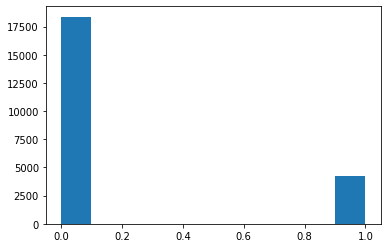

In [ ]:
plt.hist(trainDfEng["label"])

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk import word_tokenize

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()

def clean(text, stem = False):
    # Lowering letters
    text = text.lower()
    # Removing html tags
    text = re.sub('<[^>]*>', '', text)
    # Removing emails
    text = re.sub('\S*@\S*\s?', '', text)
    # Removing urls
    text = re.sub('https?://[A-Za-z0-9]','',text)
    # Removing numbers
    text = re.sub('[^a-zA-Z"]',' ',text)
    word_tokens = word_tokenize(text)    
    filtered_sentence = []
    for word_token in word_tokens:
      if stem:
        if word_token != lemmatizer.lemmatize(word_token, "v"):
          word_token = lemmatizer.lemmatize(word_token, "v")

      filtered_sentence.append(word_token)
    
    # Joining words
    text = (' '.join(filtered_sentence))
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
all_cleaned_texts = np.array([clean(text) for text in trainDfEng["sentence"]])

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(all_cleaned_texts)

all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

maxlen = max([len(sent) for sent in all_encoded_texts])
all_encoded_texts = tf.keras.preprocessing.sequence.pad_sequences(all_encoded_texts, maxlen= maxlen)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
def getEmbedding(mode = "GN300"):
  import multiprocessing
  import gensim
  import gensim.downloader as api
  import os

  dim = 300

  if mode == "customTrained":
    modelW2V = gensim.models.Word2Vec(all_cleaned_texts, size= dim, min_count = 2, window = 5, sg=0, iter = 10, workers= multiprocessing.cpu_count() - 1)
  elif mode == "GN300":
    word2vec = api.load("word2vec-google-news-300")
    dim = 300
  elif mode == "glove":
    path_to_glove_file = os.path.join(
        "./glove.6B.300d.txt"
    )
    dim = 300

    word2vec = {}
    with open(path_to_glove_file) as f:
        for line in f:
            word, coefs = line.split(maxsplit=1)
            coefs = np.fromstring(coefs, "f", sep=" ")
            word2vec[word] = coefs

    print("Found %s word vectors." % len(word2vec))
  else:
    word2vec = hub.load("https://tfhub.dev/google/nnlm-en-dim128/2")
    dim = 128

  num_words = len(list(tokenizer.word_index))

  embedding_matrix = np.random.uniform(-1, 1, (num_words + 1, dim))
  for word, i in tokenizer.word_index.items():
      if i < num_words:
        try:
          embedding_vector = word2vec.get_vector(word)
          if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
          else:
            embedding_matrix[i] = np.zeros((dim,))
        except:
          pass

  embedding_matrix[num_words] = np.zeros((dim,))
  return embedding_matrix

EMBED_MODE = "NNLM"

embedding_matrix = getEmbedding(EMBED_MODE)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(all_encoded_texts, trainDfEng["label"], test_size=0.2, random_state=42)
# X_train, y_train = all_encoded_texts, trainDfEng["label"]

## MODELS

In [ ]:
from sklearn.metrics import f1_score

class MacroF1Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    y_pred = self.model.predict(X_train)

    print("Train F1 Score: ", f1_score(y_train, y_pred > 0.5, average = "macro"))
    
    y_pred = self.model.predict(X_test)

    print("Test F1 Score: ", f1_score(y_test, y_pred > 0.5, average = "macro"))

In [ ]:
TRAIN_EMBED = False
DROPOUT = 0.5

def get_model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.Embedding(input_dim= embedding_matrix.shape[0],
                                                                output_dim= embedding_matrix.shape[1],
                                                                weights = [embedding_matrix],
                                                                input_length= maxlen,
                                                              trainable = TRAIN_EMBED),
                                      tf.keras.layers.Conv1D(128, 3, activation= "relu", padding= "same"),
                                      tf.keras.layers.GlobalMaxPool1D(),
                                      tf.keras.layers.Dropout(DROPOUT),
                                      tf.keras.layers.Dense(64, activation= "relu", kernel_regularizer= tf.keras.regularizers.l2(1e-4)),
                                      tf.keras.layers.Dense(1, activation= "sigmoid")
                                      ]
  )

  model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy', "AUC"])
  
  return model

In [ ]:
model = get_model()

PARAMS = {"train_embed": TRAIN_EMBED, "embedding": EMBED_MODE, "dropout": DROPOUT, "batch_size": 16, "weights": 1}

run["model_name"] = "CNN"
run["hyper-parameters"] = PARAMS

model.fit(X_train, y_train, validation_data= (X_test, y_test), batch_size= 16, epochs= 100, callbacks= [
    tf.keras.callbacks.EarlyStopping(patience= 3, verbose = 1, monitor = "val_auc", mode= "max"), 
    tf.keras.callbacks.ModelCheckpoint(monitor = "val_loss", filepath = "./modelcnn", save_best_only = True, save_weights_only = True),
    neptune_cbk,
    MacroF1Callback()
])

Epoch 1/100
1130/1130 [==============================] - 42s 11ms/step - loss: 0.5209 - accuracy: 0.8057 - auc: 0.5516 - val_loss: 0.4041 - val_accuracy: 0.8271 - val_auc: 0.8061
Train F1 Score:  0.5442274586922412
Test F1 Score:  0.5260459455490711
Epoch 2/100
1130/1130 [==============================] - 11s 10ms/step - loss: 0.4242 - accuracy: 0.8284 - auc: 0.7496 - val_loss: 0.4274 - val_accuracy: 0.8559 - val_auc: 0.8478
Train F1 Score:  0.7987080119363765
Test F1 Score:  0.7569249997830105
Epoch 3/100
1130/1130 [==============================] - 10s 9ms/step - loss: 0.3767 - accuracy: 0.8504 - auc: 0.8170 - val_loss: 0.3364 - val_accuracy: 0.8689 - val_auc: 0.8639
Train F1 Score:  0.758448077822198
Test F1 Score:  0.725909070409138
Epoch 4/100
1130/1130 [==============================] - 10s 9ms/step - loss: 0.3425 - accuracy: 0.8620 - auc: 0.8582 - val_loss: 0.3266 - val_accuracy: 0.8716 - val_auc: 0.8725
Train F1 Score:  0.7722952011914611
Test F1 Score:  0.734301662833104
Epoch

In [ ]:
model.load_weights("./modelcnn")

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, model.predict(X_test) > 0.5, digits= 4))

              precision    recall  f1-score   support

           0     0.9135    0.9532    0.9329      3678
           1     0.7467    0.6043    0.6680       839

    accuracy                         0.8884      4517
   macro avg     0.8301    0.7788    0.8005      4517
weighted avg     0.8825    0.8884    0.8837      4517



In [ ]:
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict(X_test))

In [ ]:
from sklearn.metrics import f1_score

y_pred = model.predict(X_test)

bestT = 0
bestF1 = 0
for t in thresholds:
  f1 = f1_score(y_test, y_pred > t)
  if f1 > bestF1:
    bestF1 = f1
    bestT = t

print("Best threshold: ", bestT)
print(classification_report(y_test, model.predict(X_test) > bestT))

Best threshold:  0.3424719
              precision    recall  f1-score   support

           0       0.93      0.92      0.92      3678
           1       0.65      0.69      0.67       839

    accuracy                           0.87      4517
   macro avg       0.79      0.80      0.80      4517
weighted avg       0.88      0.87      0.88      4517



# Test Predictions

In [ ]:
dfTest = pd.read_json("./test.json", lines = True)
dfTest.head()

,id,sentence
0,64573,A child ran around in a T-shirt that read: New...
1,81433,"""BJP is not confident of winning Assembly elec..."
2,74797,Sources agreed that there was a backlog in thi...
3,75687,"As Step II , the Congress appears to have emba..."
4,81126,How Chinese goods became a victim of Pakistani...


In [ ]:
all_cleaned_texts = np.array([clean(text) for text in dfTest["sentence"]])

# tokenizer = tf.keras.preprocessing.text.Tokenizer()
# tokenizer.fit_on_texts(all_cleaned_texts)

all_encoded_texts = tokenizer.texts_to_sequences(all_cleaned_texts)
all_encoded_texts = np.array(all_encoded_texts)

# maxlen = max([len(sent) for sent in all_encoded_texts])
all_encoded_texts = tf.keras.preprocessing.sequence.pad_sequences(all_encoded_texts, maxlen= maxlen)

X_test = all_encoded_texts

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


In [ ]:
y_pred = model.predict_proba(X_test)

import pickle

with open("./FinalPredictions/" + "CNN-NNLM-TRAINED2" + ".pkl", "wb") as fout:
  pickle.dump(y_pred, fout)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:425: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '
